In [1]:
import math as m
import numpy as np
import random as r
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

In [2]:
import torch
from torch import nn
from torch import optim

In [3]:
from nflows.flows.base import Flow
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedPiecewiseQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.splines.rational_quadratic import rational_quadratic_spline
from nflows.transforms.dequantization import UniformDequantization

In [4]:
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.distributions.normal import StandardNormal
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform

In [5]:
x_prob = np.random.rand(10)
p_labels = x_prob/(np.sum(x_prob))
p_cum_labels = np.cumsum(p_labels)

In [6]:
# Define some arbitrary probability distribution
def p(x,y):
    if np.all(x > 0) and np.all(x < 1):
        return m.exp(-np.sum(x)/len(x)) * np.cos(y*m.pi*np.sum(x))**2
    return 0

def generate(n, d):
    x = np.zeros((n,d+1))

    counter = 0
    while(counter < n):
        label = np.argmax(r.random() < p_cum_labels)

        while(True):
            # Get a point
            x_trial = np.random.rand(d)
            if r.random() < p(x_trial, label):
                x[counter][:-1] = x_trial
                x[counter][-1] = label
                counter += 1
                break

    return x

In [7]:
num_layers = 5
base_dist = BoxUniform(torch.zeros(3), torch.ones(3))

transforms = []
transforms.append(UniformDequantization(max_labels=torch.tensor([-1,-1,9])))
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=3))
    transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=3, 
        hidden_features=25,
        num_bins=25,
        num_blocks=4,
    ))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [8]:
num_iter = 25000
batch_size = 500
for i in range(num_iter):
    x = generate(batch_size, 2)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    if (i % 500 == 0):
        print(loss.item())

0.7717190980911255
-0.0386698916554451
-0.08103709667921066
-0.11635436862707138
-0.09641743451356888
-0.14538291096687317
-0.14133574068546295
-0.11301896721124649
-0.1349320262670517
-0.1383025199174881
-0.1094445213675499
-0.18220750987529755
-0.14759112894535065
-0.20145712792873383
-0.1639164537191391
-0.19642746448516846
-0.1978529989719391
-0.19237282872200012
-0.19909898936748505
-0.19884908199310303
-0.1978205442428589
-0.24801380932331085
-0.2247793972492218
-0.23087504506111145
-0.24238239228725433
-0.19061240553855896
-0.23516438901424408
-0.19394169747829437
-0.23744884133338928
-0.2640780508518219
-0.29386579990386963
-0.2500395178794861
-0.2835206091403961
-0.23700053989887238
-0.2797091007232666
-0.2727116346359253
-0.2241789549589157
-0.26558905839920044
-0.28145039081573486
-0.29526984691619873
-0.27372193336486816
-0.321550190448761
-0.2909435033798218
-0.2994389832019806
-0.269363135099411
-0.29784172773361206
-0.27751240134239197
-0.23660734295845032
-0.30588728189

In [9]:
n_events = 1000000
x_truth = generate(n_events, 2)
with torch.no_grad():
    x_flow = flow.sample(n_events).numpy()

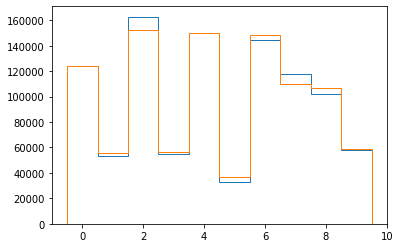

In [10]:
plt.hist(x_truth[:,2], histtype="step", bins = np.linspace(-0.5, 9.5, num=11))
plt.hist(x_flow[:,2], histtype="step", bins = np.linspace(-0.5, 9.5, num=11))
plt.show()

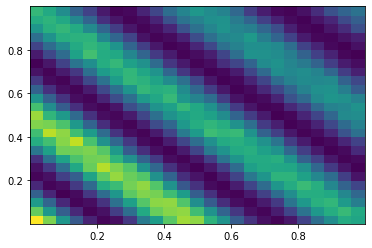

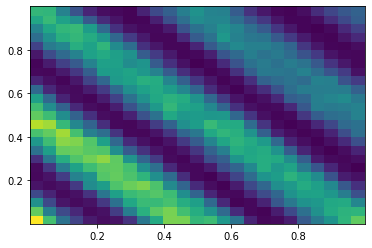

In [16]:
x_truth_0 = x_truth[x_truth[:,2] == 2]
x_flow_0  = x_flow[x_flow[:,2] == 2]
plt.hist2d(x_truth_0[:,0], x_truth_0[:,1], bins = 25)
plt.show()
plt.hist2d(x_flow_0[:,0], x_flow_0[:,1], bins = 25)
plt.show()